In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os

In [2]:
def get_cpu_df(exp_name):
    with open(f'cpu_logs/log_{exp_name}') as f:
        data = f.read()
        f.close()
    
    data = [line.strip() for line in data.split('Mem:')]
    
    i_lines = data[0].strip().split('\n')
    
    pids = json.loads(i_lines[0])
    start_time = float(i_lines[1])
    
    data = data[1:]

    rows = []

    curr_time = float(start_time)
   
    for d in data:
        
        pid_info = {
            "Time": curr_time,
            "[kswapd0]": 0,
            "lmkd": 0,
            "org.mozilla.firefox": 0,
            "org.mozilla.firefox:tab0": 0,
            "org.mozilla.firefox:media": 0,
            "com.example.myapplication": 0,
            "com.example.myapplication:ServiceProcess": 0,
            "top": 0
        }

        curr_time += 1
        
        for var in ['user', 'nice', 'sys', 'idle', 'iow', 'irq', 'sirq', 'host']:
            try:
                val = re.search(r'([\d\.]+)%' + var, d).group(1)
                pid_info[var] = float(val)
            except:
                pid_info[var] = float(0)
                
        lines = d.split('\n')
        
        for line in lines:
            for pid in pids:
                if pid + ' ' in line:
                    match = re.search(r'([\d\.]+)\s+([\d\.]+)\s+\d+:\d+\.\d+\s+', line)
                    if match ==  None:
                        print(line)
                    pid_info[pids[pid]] = float(match.group(1))
                    pid_info[pids[pid] + ' Mem'] = float(match.group(2))
            if 'top -d' in line:
                match = re.search(r'([\d\.]+)\s+([\d\.]+)\s+\d+:\d+\.\d+\s+', line)
                if match ==  None:
                    print(line)
                pid_info['top'] = float(match.group(1))
                pid_info['top' + ' Mem'] = float(match.group(2))

        rows.append(pid_info)

    cpu_df = pd.DataFrame(rows)
    cpu_df['Time'] = cpu_df['Time'] - start_time
    return cpu_df, start_time

In [3]:
def get_vid_df(exp_name, time_offset=-1, interval=500):
    
    if interval < 500:
        interval = 500
    div = int(interval / 500)
    
    with open(f'vid_logs/log_video_{exp_name}') as file:

        rows = []

        for line in file.readlines():
            line = line.strip().split('\t')
            vid_data = json.loads(line[7])
            
            for vid_log in vid_data:
                
                if next((row for row in rows if row[0] == vid_log['logCount']), None) == None:
                    
                    if vid_log['logCount'] == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        row.append(vid_log['frameRate'])
                        rows.append(row)
                    elif int(vid_log['logCount']) % div == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        prevTimeElapsed = rows[-1][2]
                        prevTotalFrames = rows[-1][3]
                        prevDroppedFrames = rows[-1][4]
                        frameRate = ((vid_log['totalFrames'] - prevTotalFrames) - (vid_log['droppedFrames'] - prevDroppedFrames)) / (vid_log['timeElapsed'] - prevTimeElapsed)
                        row.append(frameRate)
                        rows.append(row)
                        
    vid_df = pd.DataFrame(rows, columns=['logCount', 'Time', 'timeElapsed', 'totalFrames', 'droppedFrames', 'Frame Rate'])
    vid_df['Time'] = (vid_df['Time'] - vid_df.iloc[0]['Time'])/1000 if time_offset == -1 else vid_df['Time']/1000 - time_offset
    return vid_df

In [4]:
def append_df(i_cpu_df, i_vid_df, exp_name, fps, res, mem_state, run):
    cpu_df, start_time = get_cpu_df(exp_name)
    frame_rate_logging_interval = 500
    vid_df = get_vid_df(exp_name, start_time, frame_rate_logging_interval)
    cpu_df['fps'] = fps
    cpu_df['res'] = res
    cpu_df['mem_state'] = mem_state
    cpu_df['run'] = run
    return i_cpu_df.append(cpu_df, ignore_index=True), i_vid_df.append(vid_df, ignore_index=True)

cpu_df = pd.DataFrame()
vid_df = pd.DataFrame()

for mem_state in ['normal', 'moderate', 'critical']:
    for run in [10, 11, 12]:
        cpu_df, vid_df = append_df(cpu_df, vid_df, f'60fps240p_{mem_state[0]}{run}', 60, 240, mem_state, run-9)

for mem_state in ['normal']:
    for run in [3, 4, 5]:
        cpu_df, vid_df = append_df(cpu_df, vid_df, f'30fps480p_{mem_state[0]}{run}', 30, 480, mem_state, run)
        
for mem_state in ['moderate', 'critical']:
    for run in [1,2,3]:
        cpu_df, vid_df = append_df(cpu_df, vid_df, f'30fps480p_{mem_state[0]}{run}', 30, 480, mem_state, run)
        
for mem_state in ['normal', 'moderate', 'critical']:
    for run in [1, 2, 3]:
        cpu_df, vid_df = append_df(cpu_df, vid_df, f'60fps480p_{mem_state[0]}{run}', 60, 480, mem_state, run)
        
for mem_state in ['normal', 'moderate', 'critical']:
    for run in [1]:
        cpu_df, vid_df = append_df(cpu_df, vid_df, f'60fps1080p_{mem_state[0]}{run}', 60, 1080, mem_state, run)
        
cpu_df.groupby(['fps', 'res', 'mem_state']).describe()[['[kswapd0]', 'lmkd', 'sys']]

[kswapd0]                                                \
                       count       mean        std  min    25%   50%   75%   
fps res  mem_state                                                           
30  480  critical      186.0  55.138710  26.725678  0.0  38.00  61.0  75.8   
         moderate      323.0  48.929102  25.406351  0.0  32.00  53.0  69.0   
         normal        381.0   1.508661   5.170728  0.0   0.00   0.0   1.0   
60  240  critical      101.0  40.867327  29.051279  0.0  12.00  45.0  67.0   
         moderate      395.0  34.658228  29.458046  0.0   3.00  34.0  58.0   
         normal        384.0   1.317448   4.236147  0.0   0.00   0.0   1.0   
    480  critical      227.0  54.077093  27.359236  0.0  38.00  60.0  75.0   
         moderate      345.0  52.893623  23.780634  0.0  41.00  57.0  69.0   
         normal        381.0   2.860630   5.534868  0.0   0.00   0.0   4.0   
    1080 critical      164.0  45.959756  29.625039  0.0  16.25  55.0  69.0   
         moderate       39.0  41.120513  21.987235  0.0  26.00  43.0  55.5   
         normal        139.0   8.330935  12.994084  0.0   0.00   1.0  12.0   

                            lmkd            ...              sys              \
                      max  count      mean  ...  75%  max  count        mean   
fps res  mem_state                          ...                                
30  480  critical   103.0  186.0  0.048387  ...  0.0  1.0  186.0  227.747312   
         moderate    96.0  323.0  0.030650  ...  0.0  1.0  323.0  226.609907   
         normal      66.0  381.0  0.000000  ...  0.0  0.0  381.0   68.918635   
60  240  critical    97.0  101.0  0.099010  ...  0.0  4.0  101.0  214.900990   
         moderate    98.0  395.0  0.025316  ...  0.0  1.0  395.0  173.675949   
         normal      54.0  384.0  0.005208  ...  0.0  1.0  384.0   78.164062   
    480  critical   101.0  227.0  0.061674  ...  0.0  1.0  227.0  231.158590   
         moderate   106.0  345.0  0.040000  ...  0.0  1.0  345.0  254.176812   
         normal      31.0  381.0  0.005249  ...  0.0  1.0  381.0   88.338583   
    1080 critical    95.0  164.0  0.030488  ...  0.0  1.0  164.0  158.006098   
         moderate    81.0   39.0  0.051282  ...  0.0  1.0   39.0  210.743590   
         normal      83.0  139.0  0.007194  ...  0.0  1.0  139.0   93.258993   

                                                                   
                           std   min    25%    50%     75%    max  
fps res  mem_state                                                 
30  480  critical    81.649585   3.0  171.5  253.0  288.75  471.0  
         moderate    84.247912  18.0  163.0  246.0  287.00  424.0  
         normal      22.027882  15.0   56.0   64.0   77.00  213.0  
60  240  critical    67.548428  21.0  171.0  225.0  258.00  368.0  
         moderate    91.418690  13.0   83.0  161.0  251.00  434.0  
         normal      18.453856  12.0   69.0   76.0   85.00  207.0  
    480  critical    95.419110   7.0  204.0  261.0  291.00  396.0  
         moderate    73.265411  13.0  220.0  264.0  307.00  443.0  
         normal      23.399017  11.0   75.0   84.0  101.00  170.0  
    1080 critical   101.965560   6.0   68.5  166.0  250.25  372.0  
         moderate    67.905010  79.0  159.0  199.0  274.50  379.0  
         normal      49.808086  21.0   52.5   80.0  127.00  237.0  

[12 rows x 24 columns]

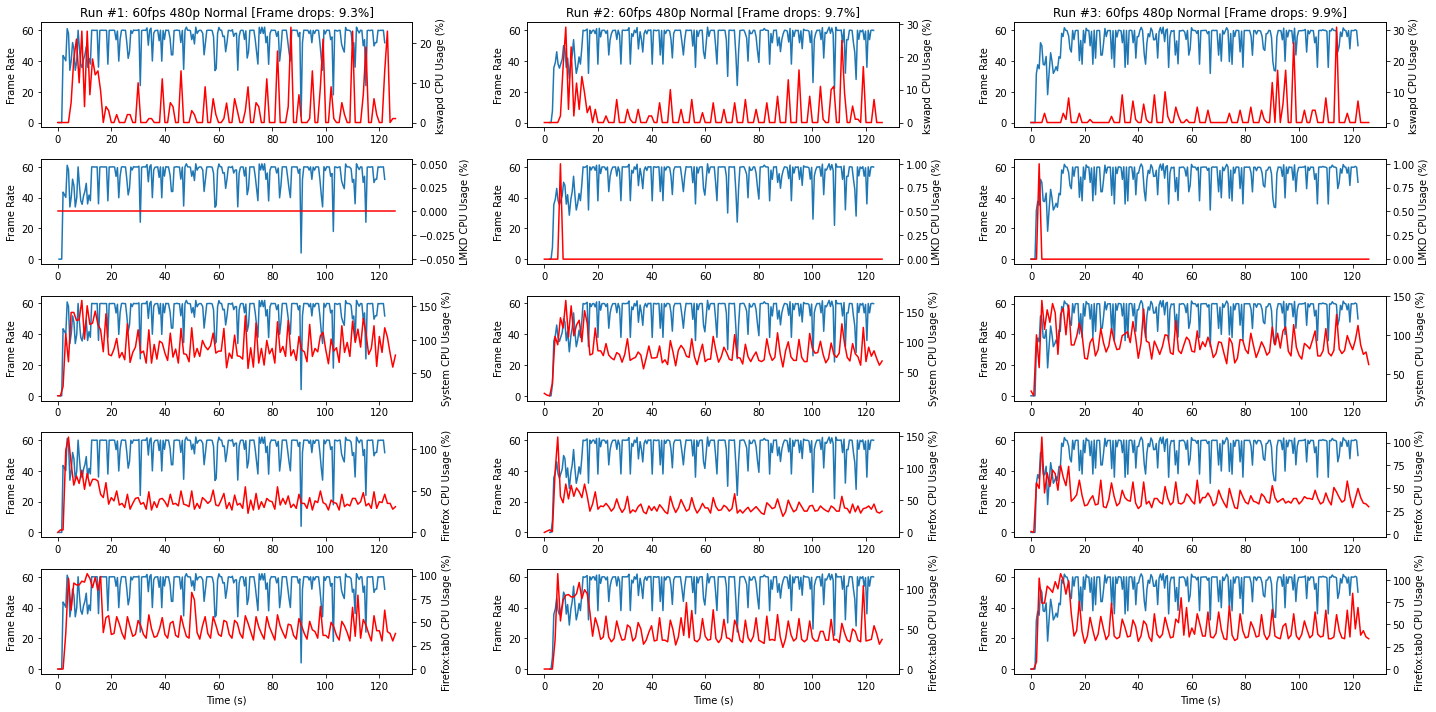

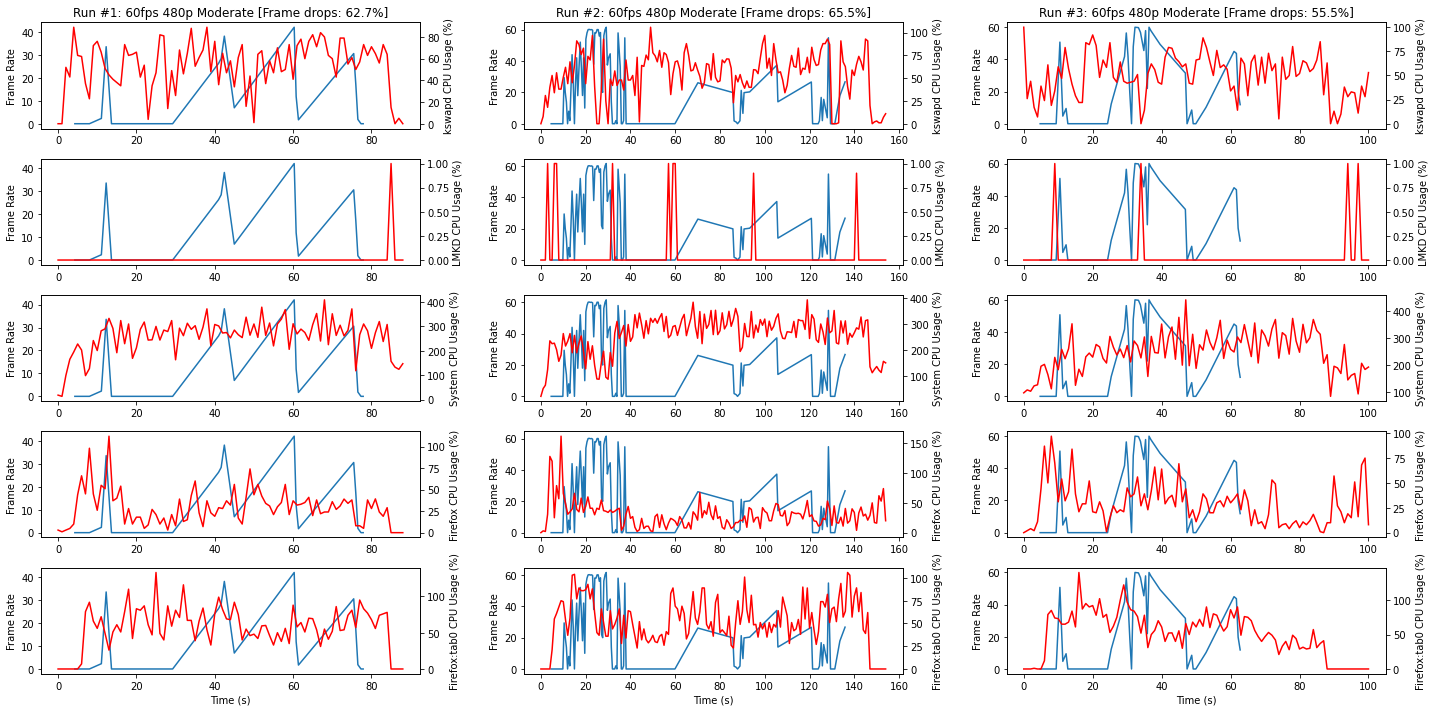

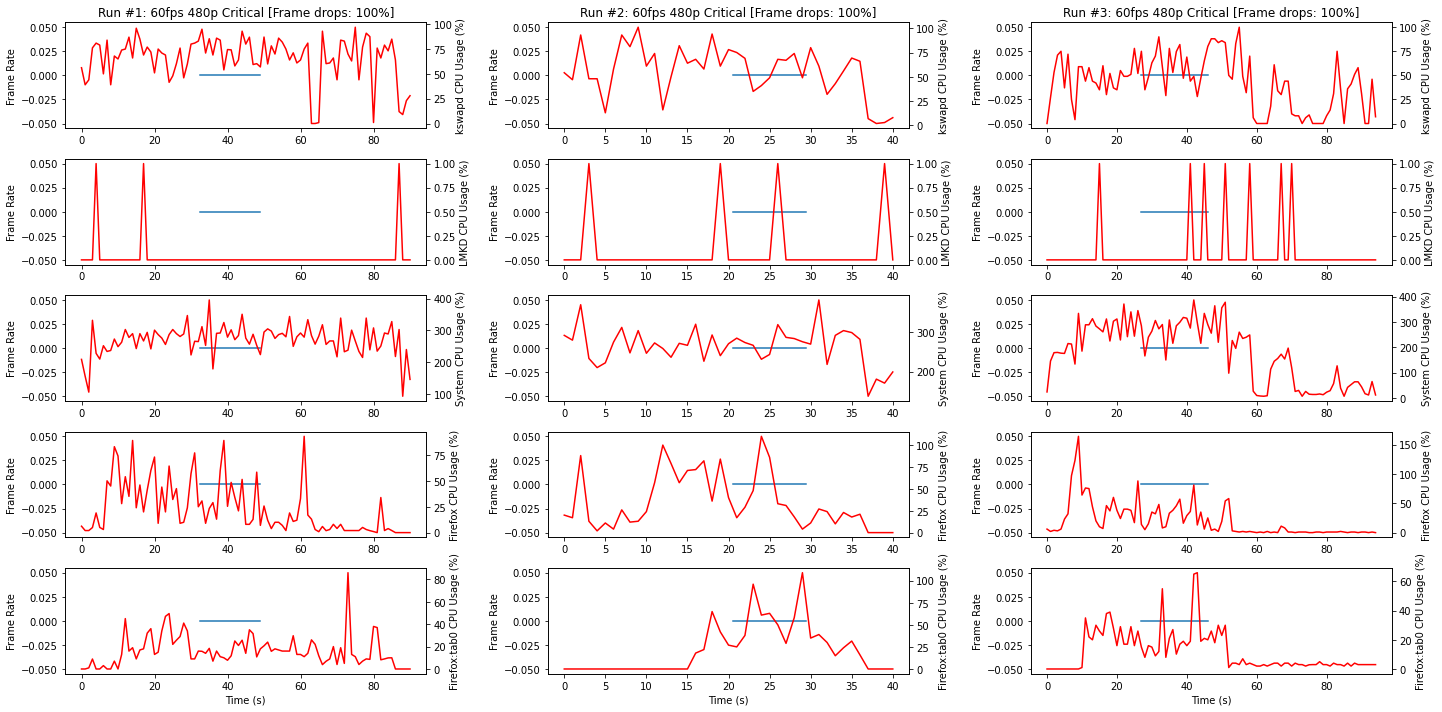

In [5]:
def plot_graph(cpu_df, vid_df, ax, y_name, x_label, ytwin_label):
    sns.lineplot(ax=ax, data=vid_df, x='Time', y='Frame Rate')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Frame Rate")
    axtwin=ax.twinx()
    sns.lineplot(data=cpu_df, x='Time', y=y_name, color='red', ax=axtwin)
    axtwin.set_ylabel(ytwin_label)

def plott(r1, r2, r3, fps, res, mem_state, make_frame_drop_100=False):
    
    fig, axes = plt.subplots(5, 3, figsize=(20,10))

    frame_rate_logging_interval = 500 # in ms (should be a multiple of 500)
    exp_name = f'{fps}fps{res}p_{mem_state[0].lower()}{r1}'

    cpu_df, start_time = get_cpu_df(exp_name)
    vid_df = get_vid_df(exp_name, start_time, frame_rate_logging_interval)

    plot_graph(cpu_df, vid_df, axes[0][0], '[kswapd0]', '', 'kswapd CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[1][0], 'lmkd', '', 'LMKD CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[2][0], 'sys', '', 'System CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[3][0], 'org.mozilla.firefox', '', 'Firefox CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[4][0], 'org.mozilla.firefox:tab0', 'Time (s)', 'Firefox:tab0 CPU Usage (%)')
    axes[0][0].set_title(f"Run #1: {fps}fps {res}p {mem_state} [Frame drops: {100  if make_frame_drop_100 else round((vid_df.iloc[-1]['droppedFrames']/vid_df.iloc[-1]['totalFrames'])*100, 1)}%]")

    frame_rate_logging_interval = 500 # in ms (should be a multiple of 500)
    exp_name = f'{fps}fps{res}p_{mem_state[0].lower()}{r2}'

    cpu_df, start_time = get_cpu_df(exp_name)
    vid_df = get_vid_df(exp_name, start_time, frame_rate_logging_interval)
    plot_graph(cpu_df, vid_df, axes[0][1], '[kswapd0]', '', 'kswapd CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[1][1], 'lmkd', '', 'LMKD CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[2][1], 'sys', '', 'System CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[3][1], 'org.mozilla.firefox', '', 'Firefox CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[4][1], 'org.mozilla.firefox:tab0', 'Time (s)', 'Firefox:tab0 CPU Usage (%)')
    axes[0][1].set_title(f"Run #2: {fps}fps {res}p {mem_state} [Frame drops: {100  if make_frame_drop_100 else round((vid_df.iloc[-1]['droppedFrames']/vid_df.iloc[-1]['totalFrames'])*100, 1)}%]")

    frame_rate_logging_interval = 500 # in ms (should be a multiple of 500)
    exp_name = f'{fps}fps{res}p_{mem_state[0].lower()}{r3}'

    cpu_df, start_time = get_cpu_df(exp_name)
    vid_df = get_vid_df(exp_name, start_time, frame_rate_logging_interval)

    plot_graph(cpu_df, vid_df, axes[0][2], '[kswapd0]', '', 'kswapd CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[1][2], 'lmkd', '', 'LMKD CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[2][2], 'sys', '', 'System CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[3][2], 'org.mozilla.firefox', '', 'Firefox CPU Usage (%)')
    plot_graph(cpu_df, vid_df, axes[4][2], 'org.mozilla.firefox:tab0', 'Time (s)', 'Firefox:tab0 CPU Usage (%)')
    axes[0][2].set_title(f"Run #3: {fps}fps {res}p {mem_state} [Frame drops: {100  if make_frame_drop_100 else round((vid_df.iloc[-1]['droppedFrames']/vid_df.iloc[-1]['totalFrames'])*100, 1)}%]")

    fig.tight_layout(w_pad=3)

    plt.savefig(f"./nokia1_why_{fps}fps{res}p_{mem_state.lower()}_cpu.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.5)

plott(1, 2, 3, 60, 480, "Normal")
plott(1, 2, 3, 60, 480, "Moderate")
plott(1, 2, 3, 60, 480, "Critical", make_frame_drop_100=True)